# NDF算法研究测试报告

In [45]:
from Module import *

from PySP.Signal import Signal,Analysis
from PySP import BasicSP
from PySP.Plot import plot_spectrum

from matplotlib import font_manager
FLOAT_EPS=1e-6
zh_font =font_manager.FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf")  # 中文字体

## 1. 测试数据导入

> 仿真脉冲信号

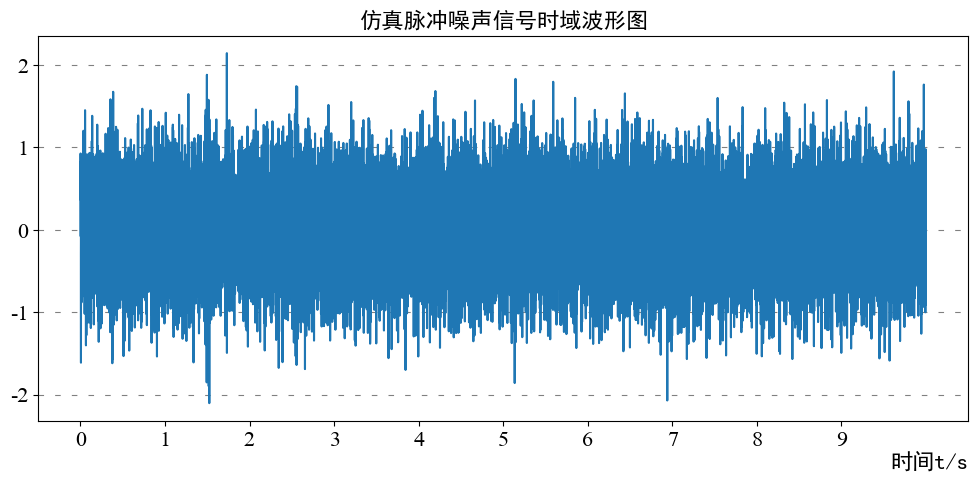

In [46]:
t=np.arange(0,10,1/2000)
impluse=np.cos(2*np.pi*1000*t[:200])*np.hanning(len(t[:200]))
data1=np.zeros(len(t))+random.randn(len(t))*0.5
data1[2900:3100]+=impluse
data1[5000:5200]+=impluse*0.75
data1[10200:10400]+=impluse*0.5
Sig_f1=Signal(data=data1,fs=2000,label="仿真脉冲噪声信号")
Sig_f1.plot()


> 仿真含噪周期信号

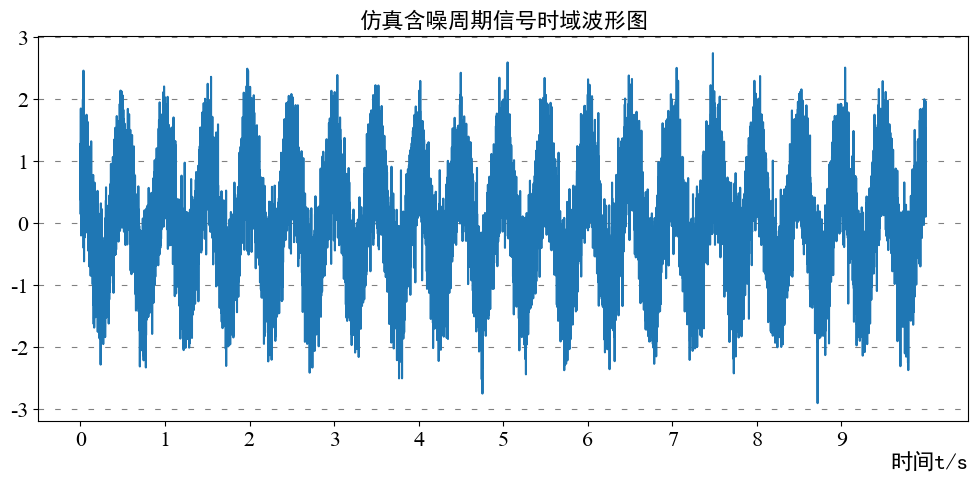

In [ ]:
t=np.arange(0,10,1/2000)
data=np.cos(2*np.pi*2*t)+random.randn(len(t))*0.5
Sig_f2=Signal(data=data,fs=2000,label="仿真含噪周期信号")
Sig_f2.plot()

> 凯斯西储大学轴承数据集

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
def CWRU_readdata(
    location: str, type: str, size: str, load: str, clock: str, FileLoc: str
) -> np.ndarray:
    """
    读取凯斯西储大学轴承数据集，指定参数下实验数据

    参数: 
    --------
    locaion: str
        故障位置, 可选值: "FE","DE12K","DE48K"
    type: str
        故障类型, 可选值: "B","IR","OR"
    size: str
        故障尺寸, 可选值: "07","14","21","28"
    load: str
        转子负载, 可选值:"0","1","2","3"
    clock: str
        轴承外圈故障方位, 当故障类型选为OR时可选值为"6","12","3"
    FileLoc: str
        数据集文件夹路径, 格式: "D:\\OneDrive\\UserFiles\\工作\\故障诊断数据库\\CRWU-bearing"
    
    返回:
    --------
    info: pd.DataFrame
        数据信息表, 包含以下列:
            点数: int
            采样频率: int
            采样时间: float
            转子转速: float
            测量位置: str
            数据: np.ndarray
            文件路径: str
    """
    # 数据集文件信息
    locaion_dict = {
        "FE": "12k Fan End Bearing Fault Data",
        "DE12K": "12k Drive End Bearing Fault Data",
        "DE48K": "48k Drive End Bearing Fault Data",
    }
    type_dict = {"B": "Ball", "IR": "Inner Race", "OR": "Outer Race"}
    clock_dict = {"6": "Centered", "12": "Opposite", "3": "Orthogonal"}
    size_dict = {"07": "0007", "14": "0014", "21": "0021", "28": "0028"}
    load_dict = {"0": "0", "1": "1", "2": "2", "3": "3"}
    file = ""
    file_name = ""
    # ---------------------------------------------------------------------------------------#
    # 生成文件路径
    # 判断故障位置参数是否正确
    if location not in locaion_dict.keys():
        raise ValueError("locaion参数错误")
    else:
        file = FileLoc + "\\" + locaion_dict[location]
    # 判断故障类型参数是否正确
    if type not in type_dict.keys():
        raise ValueError("type参数错误")
    elif type == "OR":
        # 外圈故障额外添加方位参数
        if clock not in clock_dict.keys():
            raise ValueError("clock参数错误")
        else:
            file += "\\" + type_dict[type] + "\\" + clock_dict[clock]
    else:
        file += "\\" + type_dict[type]
    # 判断故障大小参数是否正确
    if size not in size_dict.keys():
        raise ValueError("size参数错误")
    else:
        file += "\\" + size_dict[size]
    # ---------------------------------------------------------------------------------------#
    # 生成文件名
    # 判断转子负载参数是否正确
    if load not in load_dict.keys():
        raise ValueError("load参数错误")
    else:
        file_name = type + "0" + size
    if type == "OR":
        file_name += "@" + clock
    file_name += "_" + load + ".mat"  # 生成mat文件名
    # ---------------------------------------------------------------------------------------#
    # 读取数据
    file = file + ("\\" + file_name)  # 生成最终文件路径
    print(f"尝试读取文件路径: {file}")
    try:
        data = loadmat(file)  # 由于某些参数下没有实验数据，故使用try读取文件
    except FileNotFoundError:
        raise FileNotFoundError("读取失败: 不存在该参数下实验数据文件")
    print("读取成功")
    # ---------------------------------------------------------------------------------------#
    # 提取数据, 转换格式
    keys = data.keys()
    RPM = [s for s in keys if "RPM" in s][0]
    DE = [s for s in keys if "DE" in s][0]
    FE = [s for s in keys if "FE" in s][0]
    BA = [s for s in keys if "BA" in s]
    RPM = data[RPM][0][0]  # 读取转速
    DE = data[DE].flatten()  # 读取驱动端数据
    FE = data[FE].flatten()  # 读取风扇端数据
    if len(BA) != 0:
        BA = data[BA[0]].flatten()  # 读取基座数据
    # ---------------------------------------------------------------------------------------#
    # 生成数据信息表
    info = pd.DataFrame(
        columns=[
            "点数",
            "采样频率",
            "采样时间",
            "转子转速",
            "测量位置",
            "数据",
            "文件路径",
        ]
    )
    if location == "FE" or location == "DE12K":
        fs = 12000
    else:
        fs = 48000
    info.loc[0] = [len(DE), fs, len(DE) / fs, RPM, "驱动端轴承", DE, file]
    info.loc[1] = [len(FE), fs, len(FE) / fs, RPM, "风扇端轴承", FE, file]
    if len(BA) != 0:
        info.loc[2] = [len(BA), fs, len(BA) / fs, RPM, "基座", BA, file]
    return info

In [23]:
res=CWRU_readdata('DE12K','OR','14','1','6',r"D:\OneDrive\UserFiles\工作\故障诊断数据库\CWRU-bearing")
res

尝试读取文件路径: D:\OneDrive\UserFiles\工作\故障诊断数据库\CWRU-bearing\12k Drive End Bearing Fault Data\Outer Race\Centered\0014\OR014@6_1.mat
读取成功


,点数,采样频率,采样时间,转子转速,测量位置,数据,文件路径
0,122136,12000,10.178,1772,驱动端轴承,"[0.1462368862275449, -0.08440491017964072, 0.0...",D:\OneDrive\UserFiles\工作\故障诊断数据库\CWRU-bearing\...
1,122136,12000,10.178,1772,风扇端轴承,"[-0.12121818181818181, 0.08875636363636363, 0....",D:\OneDrive\UserFiles\工作\故障诊断数据库\CWRU-bearing\...
2,122136,12000,10.178,1772,基座,"[-0.01384166172106825, 0.022774362017804157, -...",D:\OneDrive\UserFiles\工作\故障诊断数据库\CWRU-bearing\...


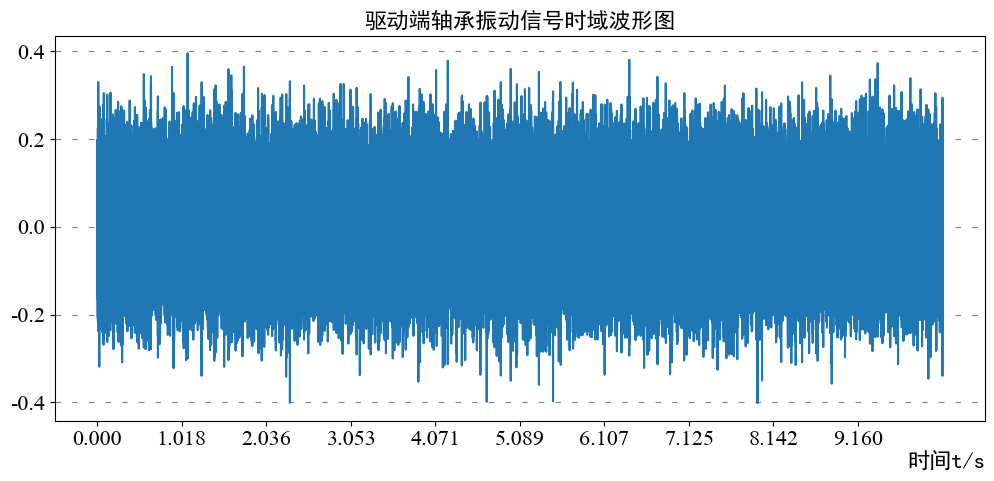

In [24]:
Sig_DE=Signal.Signal(data=res['数据'][0],label='驱动端轴承振动信号',fs=12000)
Sig_DE.plot()

## 2. 算法源代码

### 2.1 二阶自适应扩散滤波

In [84]:
import numpy as np

from PySP.Signal import Signal, Analysis
from PySP.Plot import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import font_manager

zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf")  # 中文字体

FLOAT_EPS = 1e-6


# --------------------------------------------------------------------------------------------#
# -## ----------------------------------------------------------------------------------------#
# -----## ------------------------------------------------------------------------------------#
# ---------## --------------------------------------------------------------------------------#
class NDfilter_Analysis(Analysis):
    @Analysis.Input({"Sig": {}})
    def __init__(
        self,
        Sig: Signal,
        plot: bool = False,
        plot_save: bool = False,
        **kwargs,
    ):
        super().__init__(Sig=Sig, plot=plot, plot_save=plot_save, **kwargs)
        # 该分析类的特有参数
        # ------------------------------------------------------------------------------------#

    # ----------------------------------------------------------------------------------------#
    @Analysis.Plot("1D", plot_spectrum)
    @Analysis.Input(
        {"dt": {"CloseHigh": 0.5, "CloseLow": 0.01}, "iters": {"High": 200, "Low": 10}}
    )
    def LDF(self, dt: float, iters: int):
        # 初始化
        data = self.Sig.data.copy()
        N = self.Sig.N
        # 边界条件处理
        left = np.mean(data[:100])
        right = np.mean(data[-100:])
        # ------------------------------------------------------------------------------------#
        # 隐式差分-τU_(i-1,j)+(1+2τ)U_(i,j)-τU_(i+1,j)=U_(i,j-1), 边界条件U_(0,j)=U_(N-1,j)=原始信号边界估计
        for k in range(iters):
            data[0] = left
            data[-1] = right
            _data = data.copy()  # 保持单次迭代前的数据
            # 追赶法求解原差分等价三对角线性方程组: A*U_(i,j+1)=U_(i,j)
            l = np.zeros(N)
            u = np.zeros(N)
            # 求解L*y=U_(i,j)得y
            y = np.zeros(N)
            u[0] = 1
            y[0] = data[0]
            for i in range(1, N):
                l[i] = -dt / u[i - 1]
                u[i] = 1 + 2 * dt - l[i] * (-dt)
                y[i] = data[i] - l[i] * y[i - 1]
            # 求解U*U_(i,j+1)=y得U_(i,j+1)
            data[-1] = y[-1] / u[-1]
            for i in range(N - 2, -1, -1):
                data[i] = (y[i] - (-dt) * data[i + 1]) / u[i]
            # 收敛判断
            ErrorNorm = np.linalg.norm(data - _data)
            if ErrorNorm < 0.2:
                break
        return self.Sig.t_Axis, data

    # ----------------------------------------------------------------------------------------#
    @Analysis.Plot("1D", plot_spectrum)
    @Analysis.Input(
        {
            "WinSize": {"CloseHigh": 0.5, "CloseLow": 0.01},
            "SegNum": {"High": 200, "Low": 10},
            "kappa": {"CloseHigh": 0.5, "CloseLow": 0.01},
            "iters": {"High": 200, "Low": 10},
            "dt": {"CloseHigh": 0.5, "CloseLow": 0.01},
        }
    )
    def SA_NDF(self, WinSize: float, SegNum, kappa: float, iters: int, dt: float):
        # 初始化
        data = self.Sig.data
        fs = self.Sig.fs
        filted_data = data.copy()  # 迭代过程中的滤波信号
        Delta = _Delta = np.zeros_like(data)
        G_win = NDfilter_Analysis.Gaussian(WinSize, int(WinSize * fs))
        # 计算扩散迭代过程的局部阈值
        _, thre = self.PowerFlow(WinSize * 10, SegNum)
        thre *= kappa
        for i in range(iters):
            # 计算扩散控制特征, 该特征决定扩散方向
            DiffFea = np.convolve(np.square(filted_data), G_win, "same")
            # 代入特征到扩散控制函数，得到缩放后的扩散系数
            Coe = NDfilter_Analysis.DiffusionScaler(DiffFea, thre)
            if i % 10 == 0:
                NDfilter_Analysis.plot_2lines(
                    self.Sig.t_Axis, DiffFea, thre, title=f"第{i+1}次迭代特征缩放情况"
                )
                plot_spectrum(self.Sig.t_Axis, Coe, title=f"第{i+1}次迭代扩散系数")
            # 扩散方程增量式迭代
            D2_data = self.Div2(filted_data)  # 信号二阶导
            Delta = Coe * D2_data * dt  # 单步增量
            filted_data += Delta  # 迭代
            # 收敛判断
            L = np.linalg.norm(Delta - _Delta)
            if L < 0.2:
                break
            _Delta = Delta.copy()

        print(f"迭代次数:{i+1}")
        return self.Sig.t_Axis, filted_data

    # ----------------------------------------------------------------------------------------#
    def PowerFlow(self, size: float, n: int):
        # 初始化
        data = self.Sig.data
        fs = self.Sig.fs
        # 计算功率流
        G_win = NDfilter_Analysis.Gaussian(size, int(size * fs))
        power = np.convolve(np.square(data), G_win, mode="same")  # 窗卷积计算功率流
        # 功率流分段平均化
        segstart_idx = np.linspace(0, len(power), n + 1, dtype=int)[:-1]  # 分段起始索引
        segend_idx = np.linspace(0, len(power), n + 1, dtype=int)[1:]  # 分段结束索引
        segmean_power = np.zeros_like(power)
        for i in range(n):
            power_seg = power[segstart_idx[i] : segend_idx[i]]
            segmean_power[segstart_idx[i] : segend_idx[i]] = np.mean(
                power_seg, keepdims=True
            )
        return self.Sig.t_Axis, segmean_power

    # ----------------------------------------------------------------------------------------#
    @staticmethod
    def DiffusionScaler(x: np.ndarray, lam: np.ndarray):
        return (1 - (x / lam) ** 2) / (1 + 0.5 * (x / lam) ** 4)

    # ----------------------------------------------------------------------------------------#
    @staticmethod
    def Div2(data: np.ndarray):
        kernel = [-1 / 12, 4 / 3, -5 / 2, 4 / 3, -1 / 12]  # 二阶导数的5点差分系数
        return np.convolve(data, kernel, "same")

    # ----------------------------------------------------------------------------------------#
    @staticmethod
    def Gaussian(T: float, N: int):
        if N % 2 == 0:
            t_Axis = np.linspace(-T / 2, T / 2, N, endpoint=False)
        else:
            t_Axis = np.linspace(-T / 2, T / 2, N, endpoint=True)
        sigma = (t_Axis[-1] - t_Axis[0]) / 2
        window = np.exp(-(t_Axis**2) / (2 * sigma**2))
        window /= np.sum(window)  # 归一化
        return window

    # ----------------------------------------------------------------------------------------#
    @staticmethod
    def plot_2lines(
        Axis: np.ndarray,
        data1: np.ndarray,
        data2: np.ndarray,
        **kwargs,
    ) -> None:
        """
        根据输入的横轴坐标, 和两列纵轴数据, 绘制双线Plot型谱

        参数:
        ----------
        Axis : np.ndarray
            x轴数据
        data1 : np.ndarray
            y轴数据1
        data2 : np.ndarray
            y轴数据2
        (xlabel) : str, 可选
            x轴标签, 默认为None
        (xticks) : list, 可选
            x轴刻度, 默认为None
        (xlim) : tuple, 可选
            x轴刻度范围, 默认为None
        (ylabel) : str, 可选
            y轴标签, 默认为None
        (ylim) : tuple, 可选
            y轴刻度范围, 默认为None
        (title) : str, 可选
            图像标题, 默认为None
        (plot_save) : bool, 可选
            是否将绘图结果保存为svg图片, 默认不保存
        """
        # 检查数据
        if len(Axis) != len(data1) or len(Axis) != len(data2):
            raise ValueError("输入数据长度不一致")
        # ---------------------------------------------------------------------------------------#
        # 设置图像界面
        figsize = kwargs.get("figsize", (12, 5))
        plt.figure(figsize=figsize)
        # 设置线条格式
        line1 = kwargs.get("line1", "b")
        line2 = kwargs.get("line2", "r--")
        plt.plot(Axis, data1, line1)
        plt.plot(Axis, data2, line2)
        # 设置标题
        title = kwargs.get("title", None)
        plt.title(title, fontproperties=zh_font)
        # 设置图像栅格
        plt.grid(axis="y", linestyle="--", linewidth=0.8, color="grey", dashes=(5, 10))
        # ---------------------------------------------------------------------------------------#
        # 设置坐标轴参数
        # 设置x轴参数
        xlabel = kwargs.get("xlabel", None)
        plt.xlabel(xlabel, fontproperties=zh_font, labelpad=0.2, loc="right")  # 标签
        xticks = kwargs.get("xticks", None)
        plt.xticks(xticks)  # 刻度显示
        xlim = kwargs.get("xlim", (None, None))
        plt.xlim(xlim[0], xlim[1])  # 刻度范围
        # 设置y轴参数
        ylabel = kwargs.get("ylabel", None)
        plt.ylabel(ylabel, fontproperties=zh_font, labelpad=0.2, loc="top")  # 标签
        ylim = kwargs.get("ylim", (None, None))
        plt.ylim(ylim[0], ylim[1])  # 刻度范围
        # ---------------------------------------------------------------------------------------#
        # 按指定格式保存图片并显示
        plot_save = kwargs.get("plot_save", False)
        if plot_save:
            plt.savefig(title + ".svg", format="svg")  # 保存图片
        plt.show()

## 3. 测试

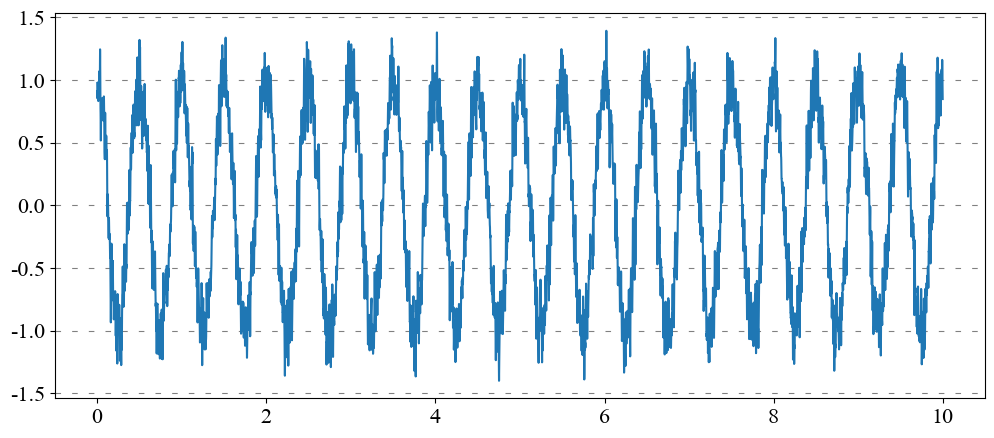

In [85]:
res=NDfilter_Analysis(Sig_f2,plot=True).LDF(dt=0.1,iters=150)

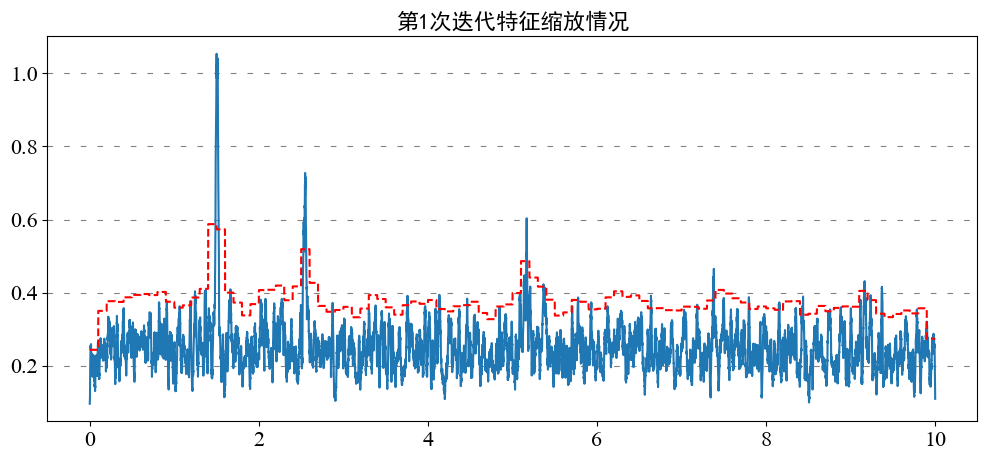

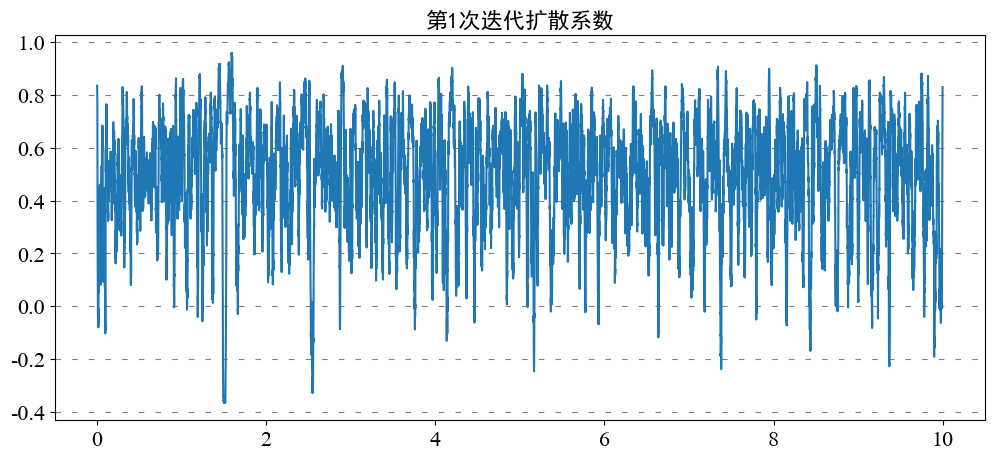

第1次迭代,收敛范数:2.223010017174482
第2次迭代,收敛范数:0.11895475620202943
第3次迭代,收敛范数:0.11177587099884012
第4次迭代,收敛范数:0.10718163371678109
第5次迭代,收敛范数:0.10531402540953622
第6次迭代,收敛范数:0.10562102627413118
第7次迭代,收敛范数:0.10721287488786378
第8次迭代,收敛范数:0.10922935045155795
第9次迭代,收敛范数:0.11101843367855004
第10次迭代,收敛范数:0.11215492806509436


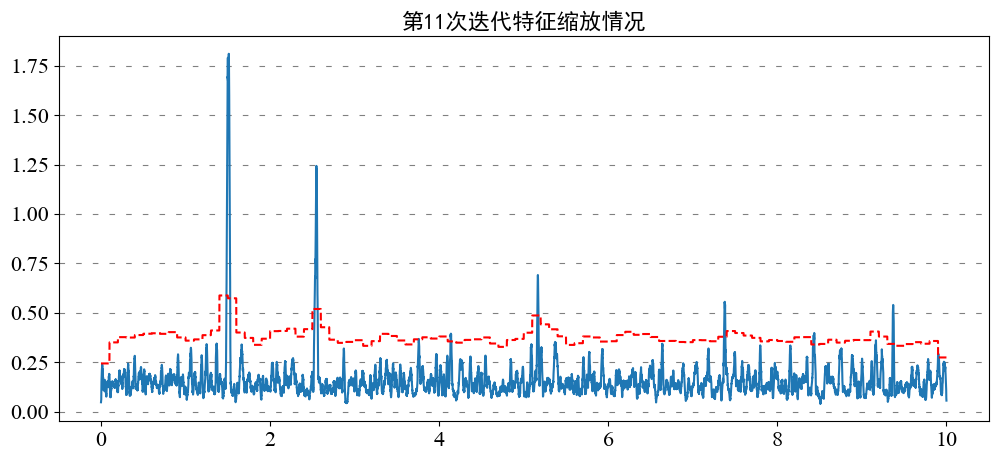

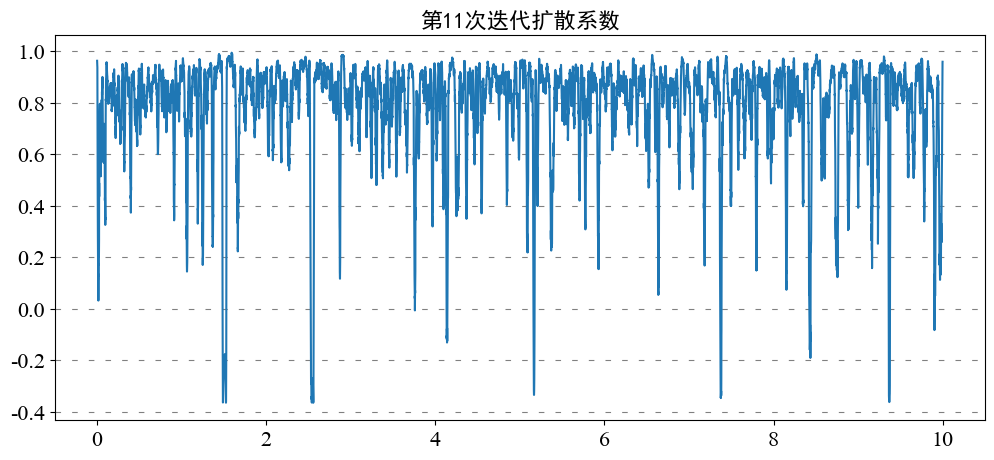

第11次迭代,收敛范数:0.11240932817683104
第12次迭代,收敛范数:0.11170996197406653
第13次迭代,收敛范数:0.11009524766686732
第14次迭代,收敛范数:0.10766580135582657
第15次迭代,收敛范数:0.10455202521270472
第16次迭代,收敛范数:0.10089818387959845
第17次迭代,收敛范数:0.09685382026054343
第18次迭代,收敛范数:0.09256437231693979
第19次迭代,收敛范数:0.08815907550758137
第20次迭代,收敛范数:0.08374062500027045


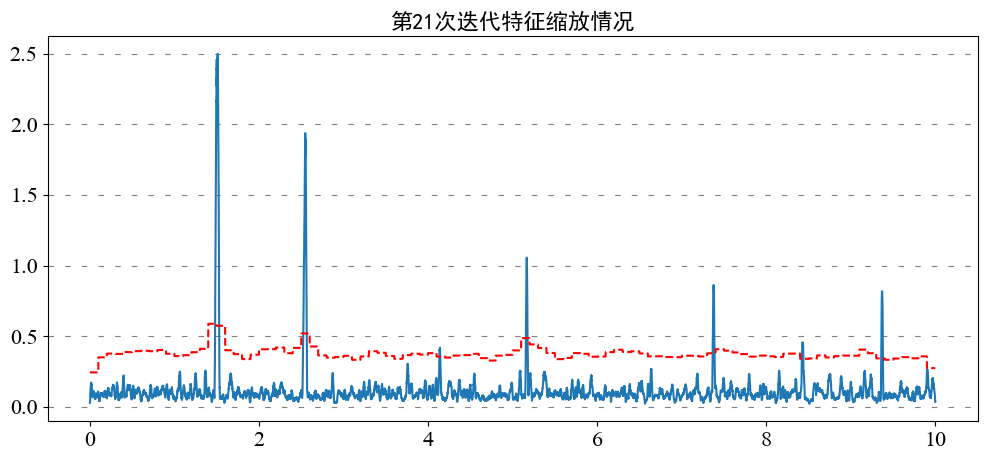

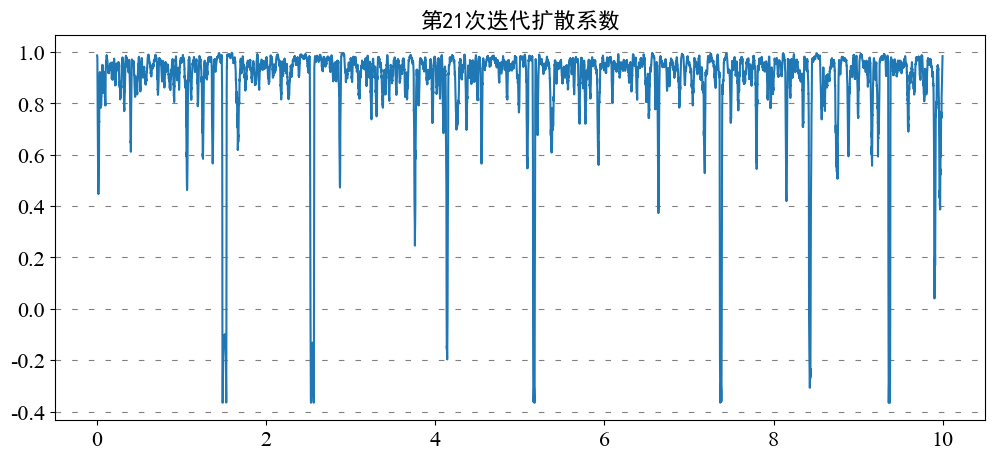

第21次迭代,收敛范数:0.07938242872146062
第22次迭代,收敛范数:0.07513389961549917
第23次迭代,收敛范数:0.071028215175814
第24次迭代,收敛范数:0.06708707109603697
第25次迭代,收敛范数:0.06332216864345322
第26次迭代,收敛范数:0.05973692839586959
第27次迭代,收敛范数:0.05633021205433129
第28次迭代,收敛范数:0.05309954552296704
第29次迭代,收敛范数:0.05004038938059631
迭代次数:30


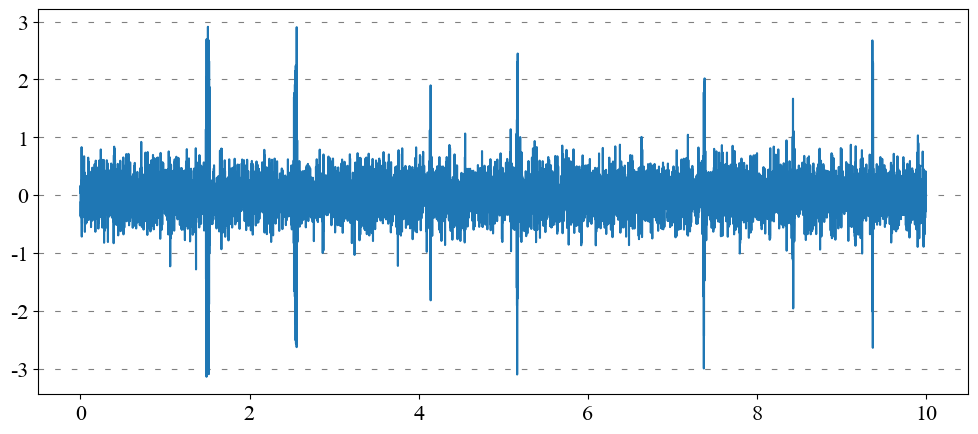

In [158]:
res=NDF_Analysis(Sig_f1,plot=True).SA_NDF(WinSize=0.02,SegNum=100,kappa=1.5,iters=100,dt=0.02)